In [4]:
!ls /content/drive/My\ Drive/station_simulation

check.py    learn_simple.ipynb	  model_20_agents_4.h5	simple.py
compare.py  learn_simple.py	  model_20_agents_5.h5	sweep.py
config.py   learn_tests.ipynb	  model_20_agents.h5
data	    model_20_agents_2.h5  model_60_agents_3.h5
Infections  model_20_agents_3.h5  __pycache__


In [1]:
#import sys
#sys.path.append("/content/drive/My Drive/station_simulation")

import random
import numpy as np
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

In [23]:
def intListToBoolList(list, n):
    vec = [0 for i in range(n)]
    for i in list:
        vec[i] = 1
    return vec

def random_adj_matrix(n, c):    # n: size of matrix, c or c-1: contacts per epoch
    adj_matrix = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        adj_matrix[i][i] = 1
        list = random.sample(range(n), c)
        for j in list:
            adj_matrix[i][j] = 1
    return adj_matrix

def matrix_to_list(matrix):
    mylist = []
    for i in range(len(matrix)):
        mylist = mylist + matrix[i]
    return mylist

def list_to_matrix(mylist, n):
    matrix = []
    for i in range(n):
        matrix.append(mylist[i*n:i*n+n])
    return matrix

def random_adj_list(n, c):
    adj_matrix = random_adj_matrix(n, c)
    return matrix_to_list(adj_matrix)

def edge(adj_list, n, i, j):
    return adj_list[i*n+j]

timesteps = 8

def generate_run(n, c, prob):
    run = [random_adj_list(n, c) for _ in range(timesteps)]
    y = [[0 for _ in range(n)] for _ in range(timesteps)]
    # first output
    y[0][0] = 1
    for j in range(n):
        if run[0][j] == 1 and random.random() < prob:
            y[0][j] = 1
    # other outputs
    for t in range(1,timesteps):
        for i in range(n):
            if y[t-1][i] == 1:
                y[t][i] = 1
            for j in range(n):
                if y[t-1][i] == 1 and random.random() < prob and edge(run[t],n,i,j) == 1:
                    y[t][j] = 1
    return run, y
    

In [21]:
#lst = random_adj_list(5,2)
print(lst)
edge(lst, 5, 4, 1)

[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1]


1

In [25]:
generate_run(5, 1, 1)

([[1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
  [1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
  [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1],
  [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1],
  [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1],
  [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
  [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
  [1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]],
 [[1, 1, 0, 0, 0],
  [1, 1, 0, 0, 1],
  [1, 1, 1, 0, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1]])

In [27]:
infect_prob = 1.0
N = 20
timesteps = 8
contacts = 2
#data_size = 500000
data_size = 1

def data_generator():
    while True:
      X_data = []
      Y_data = []
      for i in range(data_size):
        #if i % 1000 == 0:
        #    print(i)
        run, y = generate_run(N, contacts, infect_prob)
        X_data.append(run)
        Y_data.append(y)
      X_data = np.array(X_data).reshape(data_size,timesteps,N*N)
      Y_data = np.array(Y_data).reshape(data_size,timesteps,N)
      yield X_data, Y_data

def valid_data(n):
      X_data = []
      Y_data = []
      for i in range(n):
        run, y = generate_run(N, contacts, infect_prob)
        X_data.append(run)
        Y_data.append(y)
      X_data = np.array(X_data).reshape(n,timesteps,N*N)
      Y_data = np.array(Y_data).reshape(n,timesteps,N)
      return X_data, Y_data

ValueError: too many values to unpack (expected 2)

In [30]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation="tanh", input_shape=(None,N*N)))
#model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation="tanh"))
#model.add(Dropout(0.2))
#model.add(LSTM(256, return_sequences=True, activation="tanh"))
#model.add(Dense(32, activation="tanh"))
model.add(Dense(N, activation="sigmoid"))

model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [31]:
#history = model.fit(X_data, Y_data, epochs=1, validation_split=0.2, verbose=1, batch_size=10)
history = model.fit_generator(data_generator(), epochs=1, steps_per_epoch=10, verbose=1)

10/10 [==============================] - 9s 890ms/step - loss: 0.5489


<Figure size 432x288 with 0 Axes>

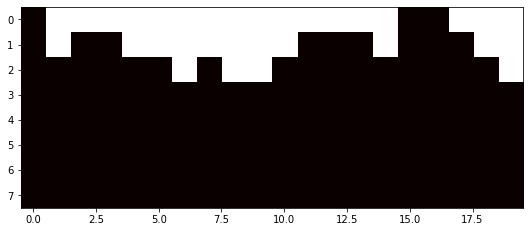

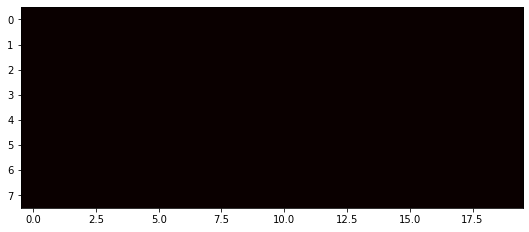

In [32]:
import matplotlib.pyplot as plt

#a = np.random.random((16, 16))
#plt.imshow(a, cmap='hot', interpolation='nearest')
#plt.show()

threshold = 0.5

T_data = []
y_data = []

run, y = generate_run(N, contacts, infect_prob)
T_data.append(run)
T_data = np.array(T_data).reshape(1,timesteps,N*N)
y_data.append(y)
y_data = np.array(y_data).reshape(timesteps,N)

test_output = model.predict(T_data, verbose=0)
pred = np.around(test_output - threshold + 0.5,0)
#pred = np.around(test_output,3)
pred = pred.reshape(timesteps,N)

#f = plt.figure()
#plt.figure(figsize=(9,9))
#plt.subplot(1, 2, 1)
#plt.imshow(1-y_data, cmap='hot', interpolation='nearest')
#plt.subplot(1, 2, 2)
#plt.imshow(1-pred, cmap='hot', interpolation='nearest')
#plt.tight_layout()
#plt.show(block=True)

f = plt.figure()
plt.figure(figsize=(9,9))
plt.imshow(1-y_data, cmap='hot', interpolation='nearest')
plt.show(block=True)
plt.figure(figsize=(9,9))
plt.imshow(1-pred, cmap='hot', interpolation='nearest')
plt.show(block=True)


<Figure size 432x288 with 0 Axes>

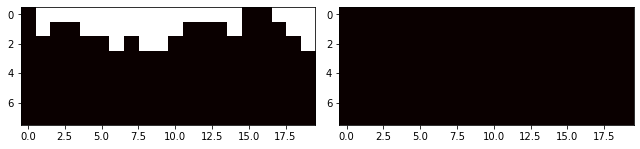

In [33]:
pred = np.around(test_output,0)
pred = pred.reshape(timesteps,N)

f = plt.figure()
plt.figure(figsize=(9,9))
plt.subplot(1, 2, 1)
plt.imshow(1-y_data, cmap='hot', interpolation='nearest')
plt.subplot(1, 2, 2)
plt.imshow(1-pred, cmap='hot', interpolation='nearest')
plt.tight_layout()
plt.show(block=True)

In [34]:
X_data, Y_data = valid_data(1000)
eval = model.evaluate(X_data,Y_data)

1000/1000 [==============================] - 2s 2ms/sample - loss: 0.3893


In [0]:
model.save('/content/drive/My Drive/station_simulation/model_60_agents_3.h5')
#model.save('model_60_agents_1.h5')